# Combining queries — a submission to MSMARCO Document challenge

In this example, we'll walk through the process of building a more complete and complex query for the MSMARCO Document dataset. This assumes that you are familiar with optimizing a basic query as shown in the "Query Tuning" notebook. We'll be using that query and the optimal parameters found there as the foundation on which we build a more complex query.

As with the previous notebook and in accordance with the MSMARCO Document ranking task, we'll continue to use MRR@100 on the `dev` dataset for evaluation and comparison with other approaches.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import importlib
import os
import sys

from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [5]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, optimize_query_mrr100
from qopt.optimize import Config

In [6]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://35.234.93.126:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 30

## Starting point: cross_fields

Let's quickly review the steps we made in the "Query Tuning" notebook. We first used a `multi_match` `cross_fields` query which searches for terms across the `url`, `title` and `body` fields of our documents. We set the parameters to their defualt values and found an MRR@100 of about `0.248`.

Next we optimized all of the parameters trying both stepwise and then all-in-one using Bayesian optimization. We evaluated again and found an MRR@100 of about `0.296`, which is quite a decent improvement over the baseline with default parameters.

Below are the optimial parameters that we found, and we'll reuse them in this notebook. Since we'll have multiple queries and sometimes the parameter names will be the same, we'll namespace them and prefix the names with `cross_fields|`.

In [14]:
cross_fields_params = {
    'cross_fields|operator': 'OR',
    'cross_fields|minimum_should_match': 40,
    'cross_fields|tie_breaker': 0.2956536905591155,
    'cross_fields|url|boost': 1.03035723802844,
    'cross_fields|title|boost': 10.0,
    'cross_fields|body|boost': 6.270734180132099,
}

## Alternative query: best_fields

The first query type we used was a `multi_match` `cross_fields` query. This searches for query terms individually across each of the three document fields. For example, given a query string "impact of the success of the manhattan project", we search for each of the query terms in each of the fields. So we could have "impact" matching the body only, while "manhattan" could match all three fields. Due to the nature of the queries which are all questions, this might not be the best query type to use.

In this step, we're going to try using [the `multi_match` query of type `best_fields`](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-multi-match-query.html#type-best-fields). This variant will look across fields but will only return the field and score with the best matches. We will also experiment in this query with modifying a few parameters of the query that are sometimes hard to guess at. Specifically, we'll explore which field boosts to use for each of our three fields and also which `tie_breaker` parameter to use.

Here's the baseline query with default parameter values.

In [10]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches,
    template_id='best_fields',
    params={
        'tie_breaker': 0.0,
        'url|boost': 1.0,
        'title|boost': 1.0,
        'body|boost': 1.0,
    })

Score: 0.2799
CPU times: user 2 s, sys: 609 ms, total: 2.61 s
Wall time: 41.9 s


That's pretty impressive for the baseline query. It beats our baseline `cross_fields` query, but not quite the optimized one.

Let's try and optimize this `best_fields` query now. We'll put all the parameters into a single large parameter space and use Bayesian optimization again to find the optimal parameters.

In [11]:
%%time

_, _, final_params_best_fields, metadata_best_fields = optimize_query_mrr100(es, max_concurrent_searches,
    template_id='best_fields',
    config_space=Config.parse({
        'num_iterations': 50,
        'num_initial_points': 10,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        },
    }))

Optimizing parameters
 - iteration 1 scored 0.1984 with: {'tie_breaker': 0.835838815676778, 'url|boost': 2.1391555484465115, 'title|boost': 5.936928134478353, 'body|boost': 0.3575464234918591}
 - iteration 2 scored 0.2216 with: {'tie_breaker': 0.19602557614706223, 'url|boost': 1.6274001250661898, 'title|boost': 7.0026441707216165, 'body|boost': 1.9315136389573557}
 - iteration 3 scored 0.2130 with: {'tie_breaker': 0.08468148306233948, 'url|boost': 2.830814282996708, 'title|boost': 4.762862153679114, 'body|boost': 0.3827282100351626}
 - iteration 4 scored 0.1745 with: {'tie_breaker': 0.9201958324424367, 'url|boost': 8.066784849357466, 'title|boost': 6.824341099584542, 'body|boost': 2.6312453869077395}
 - iteration 5 scored 0.2219 with: {'tie_breaker': 0.0028070460397922052, 'url|boost': 7.222439197401668, 'title|boost': 5.587857721081876, 'body|boost': 5.352059296430413}
 - iteration 6 scored 0.1901 with: {'tie_breaker': 0.8481483243709104, 'url|boost': 5.675405086773165, 'title|boost':

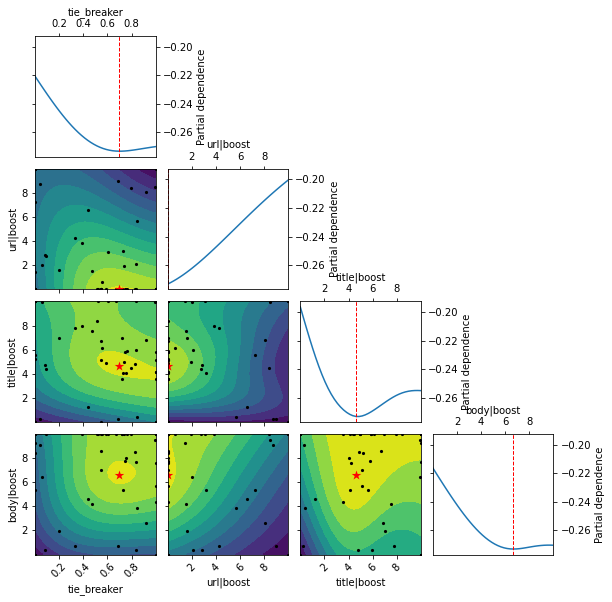

In [12]:
_ = plot_objective(metadata_best_fields, sample_source='result')

In [16]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, template_id='best_fields', params=final_params_best_fields)

Score: 0.3000
CPU times: user 2.03 s, sys: 616 ms, total: 2.64 s
Wall time: 3min 21s


That's a nice improvement on an already good score and it approximately matches the optimal score from `cross_fields`.

## Combining queries

REVIEW

We've seen the process to optimize field weights on two different `multi_match` queries but it would be interesting to see if combining them with in a parent `bool` query might actually result in even better MRR@100. Let's give it a shot and find out.

We'll combine the two queries by using a `bool` query with a `should` clause. That means that we don't require both queries to match documents, but we will combine the scores when they do. Using the `combined` template, we can use the previously discovered optimal field weights, and add some new parameters for query `boost`s to decide how we should combine these two queries.

Side note: Combining queries in this way may improve relevance as measured by MRR@100, but it will hurt performance and the query times will be quite a lot higher than with a single, simpler query. Keep this in mind when building complex queries for production!

Here's the baselines that we'll compare against when trying to combine these queries in an optimal way. First a combined query with all parameters default values, and second a combined query using the optimal field weights previously found.

In [18]:
%%time

results = evaluate_mrr100_dev(es, max_concurrent_searches,
    template_id='combined',
    params={
        'cross_fields|operator': 'OR',
        'cross_fields|minimum_should_match': 50,
        'cross_fields|tie_breaker': 1.0,
        'cross_fields|url|boost': 1.0,
        'cross_fields|title|boost': 1.0,
        'cross_fields|body|boost': 1.0,
        'best_fields|tie_breaker': 0.0,
        'best_fields|url|boost': 1.0,
        'best_fields|title|boost': 1.0,
        'best_fields|body|boost': 1.0,
    })

Score: 0.2867
CPU times: user 3.95 s, sys: 1.03 s, total: 4.97 s
Wall time: 6min 11s


Not bad for using all default values, but I think we can do better by using the optimal parameters we found for each query.

In [29]:
best_fields_params = {f'best_fields|{k}': v for k, v in final_params_best_fields.items()}
all_params = {**cross_fields_params, **best_fields_params}
all_params

{'cross_fields|operator': 'OR',
 'cross_fields|minimum_should_match': 40,
 'cross_fields|tie_breaker': 0.2956536905591155,
 'cross_fields|url|boost': 1.03035723802844,
 'cross_fields|title|boost': 10.0,
 'cross_fields|body|boost': 6.270734180132099,
 'best_fields|tie_breaker': 0.6924148954713882,
 'best_fields|url|boost': 0.046945523897465875,
 'best_fields|title|boost': 4.603294135574224,
 'best_fields|body|boost': 6.639497108731711}

In [30]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, 'combined', all_params)

Score: 0.3006
CPU times: user 4.43 s, sys: 2.53 s, total: 6.96 s
Wall time: 6min 48s


Adding boosts to tune.

In [49]:
%%time

_, _, final_params_boosts, metadata_boosts = optimize_query_mrr100(es, max_concurrent_searches,
    template_id='combined',
    config_space=Config.parse({
        'num_iterations': 30,
        'num_initial_points': 5,
        'space': {
            'cross_fields|boost': { 'low': 0.0, 'high': 5.0 },
            'best_fields|boost': { 'low': 0.0, 'high': 5.0 },
        },
        'default': all_params,
    }))

Optimizing parameters
 - iteration 1 scored 0.2761 with: {'cross_fields|boost': 4.470945354896677, 'best_fields|boost': 3.160989079792553}
 - iteration 2 scored 0.2724 with: {'cross_fields|boost': 3.610184303509943, 'best_fields|boost': 4.18679603422701}
 - iteration 3 scored 0.2726 with: {'cross_fields|boost': 3.4952002069403454, 'best_fields|boost': 4.232845610892066}
 - iteration 4 scored 0.2724 with: {'cross_fields|boost': 0.1284561372926463, 'best_fields|boost': 0.6448482610227214}
 - iteration 5 scored 0.2714 with: {'cross_fields|boost': 2.8184984226021728, 'best_fields|boost': 4.112352790003188}
 - iteration 6 scored 0.2763 with: {'cross_fields|boost': 4.670415118853681, 'best_fields|boost': 2.5692284230785822}
 - iteration 7 scored 0.2717 with: {'cross_fields|boost': 1.4047810822947602, 'best_fields|boost': 4.867183857904161}
 - iteration 8 scored 0.2760 with: {'cross_fields|boost': 4.9992756404754655, 'best_fields|boost': 2.1749367475363037}
 - iteration 9 scored 0.2745 with: 

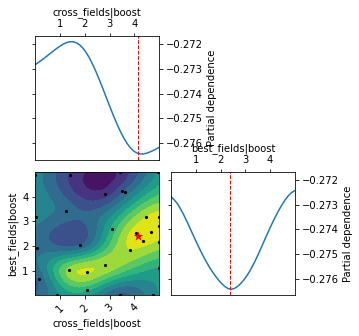

In [50]:
_ = plot_objective(metadata_boosts, sample_source='result')

In [51]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, template_id='combined', params=final_params_boosts)

Score: 0.3002
CPU times: user 3.56 s, sys: 1.91 s, total: 5.47 s
Wall time: 6min 32s


In [37]:
def collect_scores_cross_fields(query_string, doc_id):
    res = es.search(index='msmarco-document', size=100, body={ "query": {
      "multi_match": {
            "type": "cross_fields",
            "query": query_string,
            "minimum_should_match": "40%",
            "tie_breaker": 0.2956536905591155,
            "fields": [
                  "url^1.03035723802844",
                  "title^10.0",
                  "body^6.270734180132099"
            ]
      }
    }})
    return [hit['_score'] for hit in res['hits']['hits'] if hit['_id'] == doc_id]

def collect_scores_best_fields(query_string, doc_id):
    res = es.search(index='msmarco-document', size=100, body={ "query": {
        "multi_match": {
            "type": "best_fields",
            "query": query_string,
            "tie_breaker": 0.6924148954713882,
            "fields": [
                "url^0.046945523897465875",
                "title^4.603294135574224",
                "body^6.639497108731711"
            ],
      }
    }})
    return [hit['_score'] for hit in res['hits']['hits'] if hit['_id'] == doc_id]

def collect_scores(queries, qrels):
    cross_field_scores = []
    best_field_scores = []

    for query in queries:
        doc_id = list(qrels[query[0]].keys())[0]        
        cfs = collect_scores_cross_fields(query[1], doc_id)
        bfs = collect_scores_best_fields(query[1], doc_id)
        
        # keep just n scores to make sure the lists are the same length
        length = min(len(cfs), len(bfs))
        cross_field_scores.append(cfs[:length])
        best_field_scores.append(bfs[:length])

    return cross_field_scores, best_field_scores

In [39]:
from qopt.trec import load_queries_as_tuple_list, load_qrels
from qopt.notebooks import ROOT_DIR

queries = load_queries_as_tuple_list(os.path.join(ROOT_DIR, 'data', 'msmarco-document-sampled-queries.1000.tsv'))
qrels = load_qrels(os.path.join(ROOT_DIR, 'data', 'msmarco', 'document', 'msmarco-doctrain-qrels.tsv'))
cfs, bfs = collect_scores(queries, qrels)

In [40]:
from itertools import chain

cfs_flat = list(chain(*cfs))
bfs_flat = list(chain(*bfs))

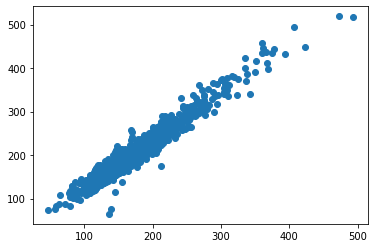

In [41]:
import matplotlib.pyplot as plt
plt.scatter(cfs_flat, bfs_flat)
plt.show()